In [12]:
%load_ext autotime
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
import matplotlib.pyplot as plt

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.94 ms


In [13]:
import sys
sys.path.extend(["../"])

time: 957 µs


In [14]:
from sklearn.model_selection import train_test_split
from core.tools.data_import import *
from core.tools.time_series import *
from constants import *

time: 1.15 ms


In [15]:
from pprint import pprint
pprint(UNRATE_DIR)
file_dir_selected = input("Select Directory ")

{'EC2': '/home/ec2-user/code/AnnEconForecast/data/UNRATE.csv',
 'MAC': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv'}
Select Directory MAC
time: 2.28 s


In [18]:
df = load_dataset(UNRATE_DIR[file_dir_selected])
df_d1 = differencing(df, periods=1, order=1)
LAGS = 24
df_d1.head()

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64


,UNRATE_period1_order1
DATE,
1948-01-01,NaN
1948-02-01,0.4
1948-03-01,0.2
1948-04-01,-0.1
1948-05-01,-0.4


time: 26.4 ms


In [19]:
X_raw, y_raw = gen_supervised_sequence(
    df_d1, LAGS, "UNRATE_period1_order1", sequential_label=True)
X_raw = X_raw.reshape(-1, LAGS,)
y_raw = y_raw.reshape(-1, LAGS,)

Total 824 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (824, 24, 1), y shape = (824, 24, 1)
time: 123 ms


In [20]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

time: 3.2 ms


In [21]:
X_scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
y_scaler = sklearn.preprocessing.StandardScaler().fit(y_train)

time: 4.73 ms


In [22]:
tx = lambda target: X_scaler.transform(target)
ty = lambda target: y_scaler.transform(target)

X_train = tx(X_train)
X_test = tx(X_test)
X_val = tx(X_val)

y_train = ty(y_train)
y_test = ty(y_test)
y_val = ty(y_val)

time: 3.74 ms


In [23]:
print(np.std(X_train))
print(np.std(y_train))

1.0000000000000002
0.9999999999999998
time: 3.77 ms


In [24]:
# Expand dimension so it fits the RNN input place holder.
# (Num_Sample, )
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

time: 1.19 ms


In [25]:
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

time: 1.32 ms


In [26]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (527, 24, 1)
y_train shape: (527, 24, 1)
X_test shape: (165, 24, 1)
y_test shape: (165, 24, 1)
X_validation shape: (132, 24, 1)
y_validation shape: (132, 24, 1)
time: 1.61 ms


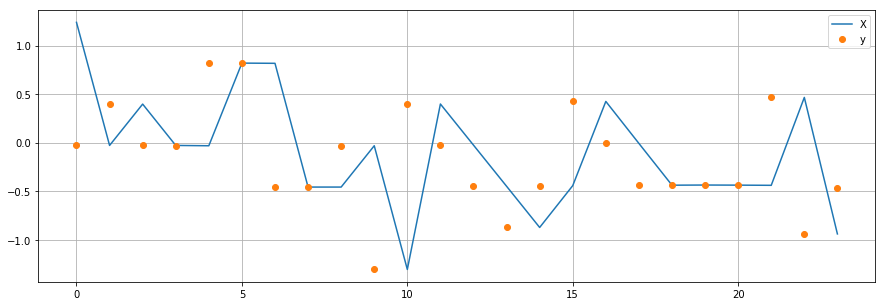

time: 301 ms


In [27]:
plt.figure(figsize=(15, 5))
plt.plot(X_train[-1])
plt.plot(y_train[-1], "o")
plt.legend(["X", "y"])
plt.grid(True)
plt.show()

In [44]:
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_neurons = 64
# Number of output series
num_outputs = 1
learning_rate = 0.1
epochs = 500
# Training Settings
REPORT_PERIOD = 10

time: 1.17 ms


In [57]:
tf.reset_default_graph()
# setting up
X = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_inputs],
    name="Input_placeholder")
y = tf.placeholder(
    tf.float32,
    [None, num_time_steps, num_outputs],
    name="Output_placeholder")
# y = tf.placeholder(
#     tf.float32,
#     [None, 1, num_outputs],
#     name="Output_placeholder")

time: 4.94 ms


In [58]:
# Build RNN.
cell = tf.contrib.rnn.LSTMCell(
    num_units=num_neurons
)
    
rnn_output, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# stacked_rnn_output = tf.reshape(rnn_output, [-1, num_neurons])

# stacked_outputs = tf.layers.dense(stacked_rnn_output, num_outputs)
# outputs = tf.reshape(stacked_outputs, [-1, num_time_steps, num_outputs])
# last_output = outputs[:, -1]
outputs = tf.layers.dense(rnn_output, num_outputs)

time: 152 ms


In [61]:
# Operators
loss = tf.reduce_sum(tf.square(outputs - y))
# loss = tf.reduce_sum(tf.square(last_output - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

time: 301 ms


In [62]:
y

<tf.Tensor 'Output_placeholder:0' shape=(?, 24, 1) dtype=float32>

time: 2.37 ms


In [63]:
hist = {"train": [], "val": []}
with tf.Session() as sess:
    sess.run(init)
    for e in range(epochs):
        sess.run(train,
                 feed_dict={X: X_train, y: y_train})
        if e % REPORT_PERIOD == 0:
            train_mse = loss.eval(feed_dict={X: X_train, y: y_train})
            val_mse = loss.eval(feed_dict={X: X_val, y: y_val})
            hist["train"].append(train_mse)
            hist["val"].append(val_mse)
            print(f"Iteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}")
    
    gen_pred = lambda src: outputs.eval(feed_dict={X: src})[:,-1]
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)
    

Iteration [0], Training MSE 150425.5156250; Validation MSE 16893.5000000
Iteration [1], Training MSE 15978.0800781; Validation MSE 1818.2038574
Iteration [2], Training MSE 22593.4179688; Validation MSE 2866.8427734
Iteration [3], Training MSE 28817.7539062; Validation MSE 5533.5703125
Iteration [4], Training MSE 13886.7773438; Validation MSE 1214.0310059
Iteration [5], Training MSE 19127.0742188; Validation MSE 2524.8281250
Iteration [6], Training MSE 12985.7060547; Validation MSE 1198.9409180
Iteration [7], Training MSE 14728.9140625; Validation MSE 1846.4843750
Iteration [8], Training MSE 13605.5761719; Validation MSE 1393.7045898
Iteration [9], Training MSE 13419.2617188; Validation MSE 1275.9291992
Iteration [10], Training MSE 14036.1523438; Validation MSE 1436.4389648
Iteration [11], Training MSE 12777.0332031; Validation MSE 1192.3059082
Iteration [12], Training MSE 13588.8476562; Validation MSE 1508.9592285
Iteration [13], Training MSE 13026.4921875; Validation MSE 1352.8992920


Iteration [114], Training MSE 10520.4804688; Validation MSE 1062.7563477
Iteration [115], Training MSE 10515.3330078; Validation MSE 1069.2380371
Iteration [116], Training MSE 10468.6738281; Validation MSE 1054.8466797
Iteration [117], Training MSE 10489.6894531; Validation MSE 1059.1000977
Iteration [118], Training MSE 10495.9814453; Validation MSE 1071.5717773
Iteration [119], Training MSE 10440.8671875; Validation MSE 1055.6567383
Iteration [120], Training MSE 10448.9375000; Validation MSE 1059.0939941
Iteration [121], Training MSE 10468.3398438; Validation MSE 1071.6326904
Iteration [122], Training MSE 10417.6904297; Validation MSE 1055.4650879
Iteration [123], Training MSE 10408.8320312; Validation MSE 1053.7265625
Iteration [124], Training MSE 10428.0996094; Validation MSE 1063.9965820
Iteration [125], Training MSE 10393.9667969; Validation MSE 1051.0581055
Iteration [126], Training MSE 10369.4902344; Validation MSE 1048.3837891
Iteration [127], Training MSE 10375.4648438; Valida

Iteration [228], Training MSE 9863.5410156; Validation MSE 1087.1770020
Iteration [229], Training MSE 9925.6347656; Validation MSE 1090.8425293
Iteration [230], Training MSE 9672.6445312; Validation MSE 1053.3449707
Iteration [231], Training MSE 9817.6464844; Validation MSE 1116.6147461
Iteration [232], Training MSE 9733.4785156; Validation MSE 1061.9555664
Iteration [233], Training MSE 9740.2333984; Validation MSE 1062.6385498
Iteration [234], Training MSE 9736.3281250; Validation MSE 1106.6196289
Iteration [235], Training MSE 9577.5126953; Validation MSE 1053.8709717
Iteration [236], Training MSE 9675.5332031; Validation MSE 1065.2287598
Iteration [237], Training MSE 9639.0976562; Validation MSE 1087.3973389
Iteration [238], Training MSE 9544.5800781; Validation MSE 1066.8271484
Iteration [239], Training MSE 9589.4589844; Validation MSE 1058.2166748
Iteration [240], Training MSE 9530.4980469; Validation MSE 1076.1132812
Iteration [241], Training MSE 9479.9033203; Validation MSE 1059.

Iteration [342], Training MSE 8527.7158203; Validation MSE 1148.9086914
Iteration [343], Training MSE 8519.4326172; Validation MSE 1148.3280029
Iteration [344], Training MSE 8513.2324219; Validation MSE 1154.1562500
Iteration [345], Training MSE 8514.6083984; Validation MSE 1151.7677002
Iteration [346], Training MSE 8551.6435547; Validation MSE 1169.5452881
Iteration [347], Training MSE 8725.8164062; Validation MSE 1181.2039795
Iteration [348], Training MSE 9356.4160156; Validation MSE 1288.1846924
Iteration [349], Training MSE 9680.8027344; Validation MSE 1370.9562988
Iteration [350], Training MSE 8973.8964844; Validation MSE 1211.7700195
Iteration [351], Training MSE 8733.2998047; Validation MSE 1144.4238281
Iteration [352], Training MSE 8579.2597656; Validation MSE 1133.4365234
Iteration [353], Training MSE 8778.7871094; Validation MSE 1172.8182373
Iteration [354], Training MSE 8639.2812500; Validation MSE 1127.4868164
Iteration [355], Training MSE 8563.3437500; Validation MSE 1150.

Iteration [456], Training MSE 7878.6728516; Validation MSE 1279.0471191
Iteration [457], Training MSE 7709.6777344; Validation MSE 1309.5911865
Iteration [458], Training MSE 8020.3974609; Validation MSE 1212.8989258
Iteration [459], Training MSE 7739.6015625; Validation MSE 1346.0599365
Iteration [460], Training MSE 7741.9101562; Validation MSE 1297.7705078
Iteration [461], Training MSE 7564.1079102; Validation MSE 1286.7705078
Iteration [462], Training MSE 7635.1562500; Validation MSE 1269.1298828
Iteration [463], Training MSE 7553.2412109; Validation MSE 1269.8261719
Iteration [464], Training MSE 7628.1586914; Validation MSE 1346.3046875
Iteration [465], Training MSE 7661.8447266; Validation MSE 1217.6232910
Iteration [466], Training MSE 7631.9741211; Validation MSE 1338.6772461
Iteration [467], Training MSE 7614.1777344; Validation MSE 1282.8759766
Iteration [468], Training MSE 7682.4824219; Validation MSE 1432.8070068
Iteration [469], Training MSE 7913.6323242; Validation MSE 1263.

In [65]:
# clean = lambda x: np.squeeze(x[:, -1: ])
# pred_train = clean(pred_train)
# pred_val = clean(pred_val)
# pred_test = clean(pred_test)

time: 618 µs


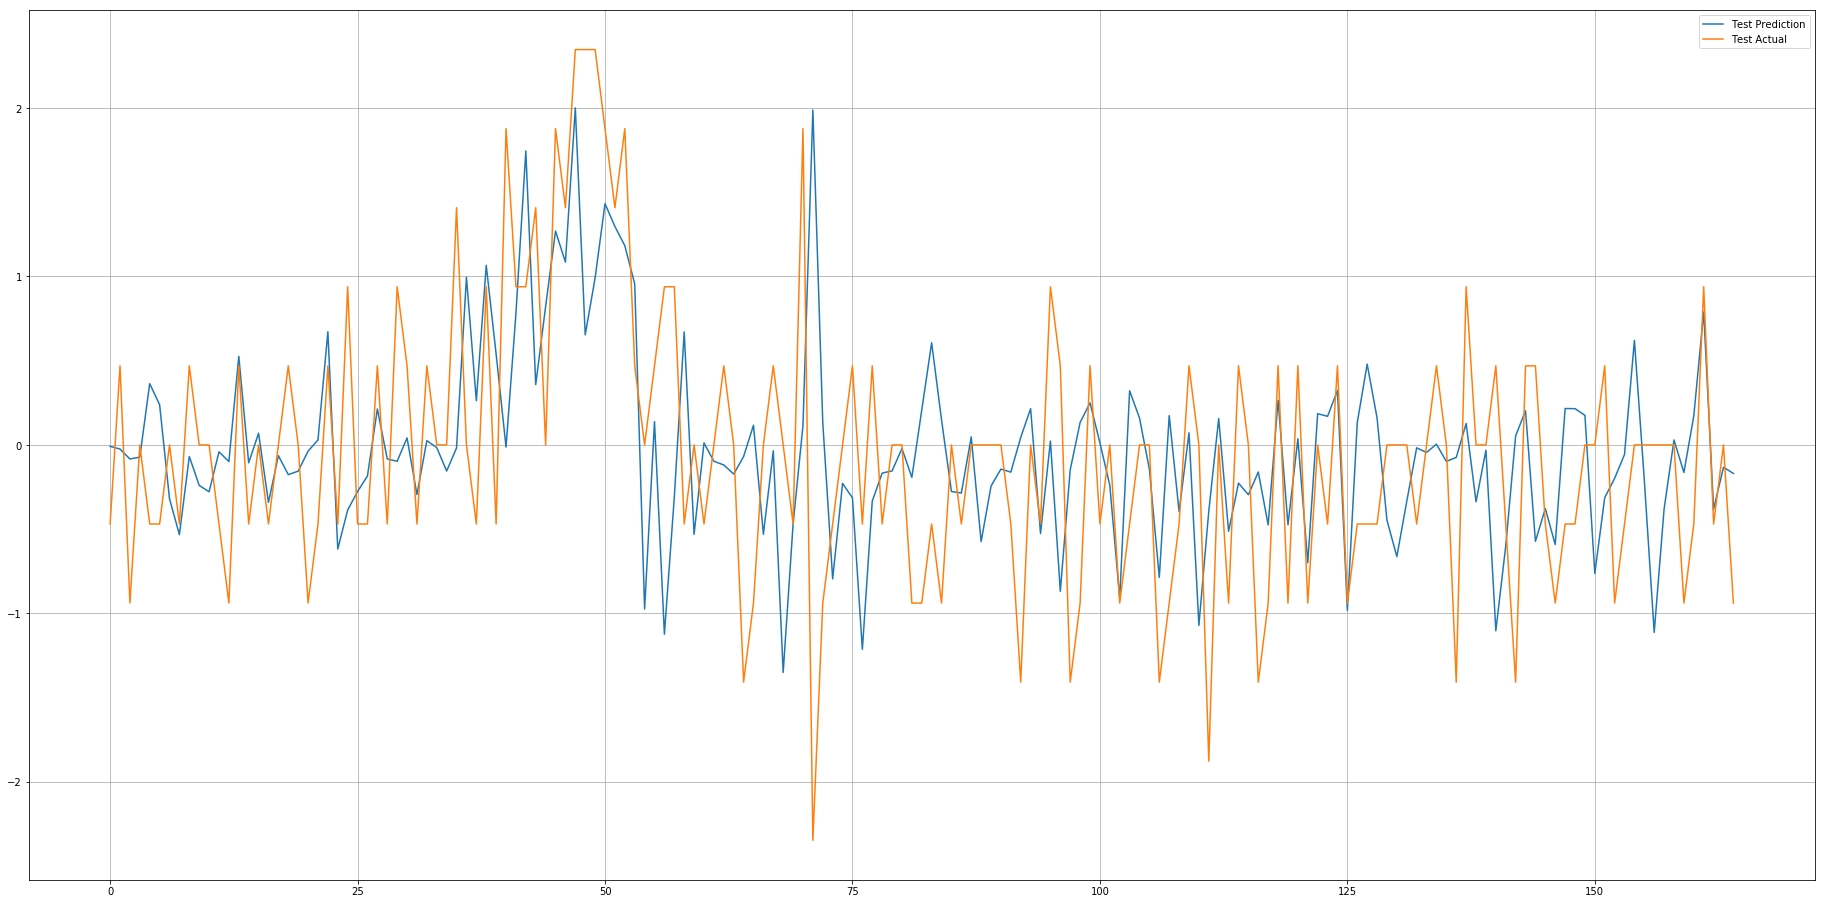

time: 997 ms


In [66]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_test[:,-1]))
plt.plot(np.squeeze(y_test[:,-1]))
plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

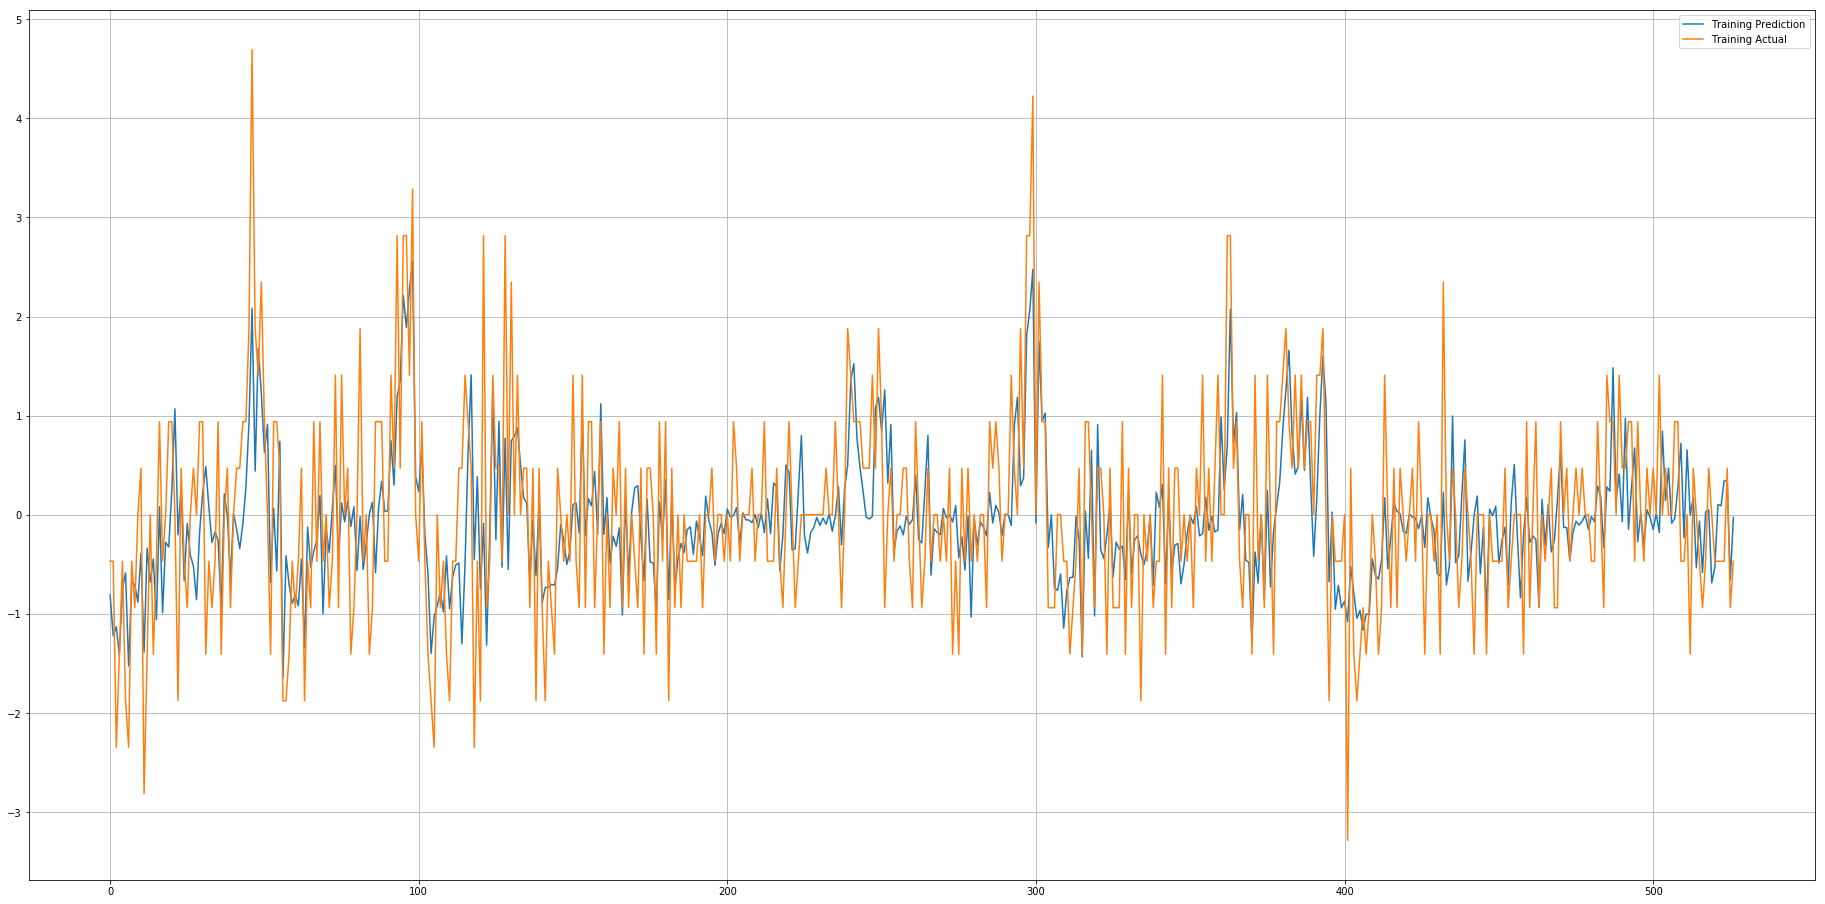

time: 1.07 s


In [67]:
plt.close()
plt.figure(figsize=(32,16))
plt.plot(np.squeeze(p_train))
plt.plot(np.squeeze(y_train[:,-1]))
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

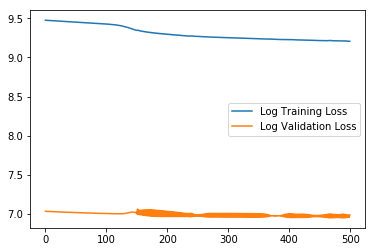

time: 201 ms


In [53]:
plt.close()
plt.plot(np.log(hist["train"]))
plt.plot(np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()